In [1]:
import pprint
import json

import numpy as np
np.random.seed(17) # fix NumPy random number generator seed


import networkx as nx
import matplotlib.pyplot as plt

import sampling

# Introduction

We leverage the `networkx` package for our graph objects.  We have gently extended the `networkx.Graph` class to the `sampling.Graph` class to include some additional methods for our convenience.

This workbook demonstrates creating and working with `sampling.Graph` objects.

A benchmark performer is *not required* to use any of the `sampling.py` functionality to run the benchmark.  A benchmark performer can go directly to the `instances` folder to obtain graph topologies and specification and sample from them using any method they want.

We will demonstrate the following ways to create a `sampling.Graph object:
* create an empty `sampling.Graph` object and later on use the `.load_nodes()` and `.load_edges()` methods to populate the data.
  * we discuss the format of the `nodes` and `edges` dictionaries that are expected.
* create a `sampling.Graph` object by passing nodes/edges as arguments into the constructor
* create a `sampling.Graph` object by passing a `networkx.Graph` object as an argument into the constructor




In [2]:
# create an empty sampling.Graph

G = sampling.Graph()

In [3]:
# we have a few utility functions to create dictionaries for nodes and edges. 
# Currently these only work for a 3D square grid model

dimensions=[3,3,1]

nodes = sampling.init_square_grid_nodes(dimensions=dimensions)

edges = sampling.init_square_grid_internal_edges(nodes=nodes)

edges = sampling.add_square_grid_periodic_boundary_edges(
    dimensions=dimensions,
    nodes=nodes,
    edges=edges
)


print("nodes (dict):")
pprint.pprint(nodes)

print("edges (dict):")
pprint.pprint(edges)

nodes (dict):
{0: {'B': 0.0, 'position': [0.0, 0.0, 0.0], 'spin': 1.0},
 1: {'B': 0.0, 'position': [0.0, 1.0, 0.0], 'spin': 1.0},
 2: {'B': 0.0, 'position': [0.0, 2.0, 0.0], 'spin': 1.0},
 3: {'B': 0.0, 'position': [1.0, 0.0, 0.0], 'spin': 1.0},
 4: {'B': 0.0, 'position': [1.0, 1.0, 0.0], 'spin': 1.0},
 5: {'B': 0.0, 'position': [1.0, 2.0, 0.0], 'spin': 1.0},
 6: {'B': 0.0, 'position': [2.0, 0.0, 0.0], 'spin': 1.0},
 7: {'B': 0.0, 'position': [2.0, 1.0, 0.0], 'spin': 1.0},
 8: {'B': 0.0, 'position': [2.0, 2.0, 0.0], 'spin': 1.0}}
edges (dict):
{(0, 1): {'periodic_boundary_edge': False, 'weight': 1.0},
 (0, 2): {'periodic_boundary_edge': True, 'weight': 1.0},
 (0, 3): {'periodic_boundary_edge': False, 'weight': 1.0},
 (0, 6): {'periodic_boundary_edge': True, 'weight': 1.0},
 (1, 2): {'periodic_boundary_edge': False, 'weight': 1.0},
 (1, 4): {'periodic_boundary_edge': False, 'weight': 1.0},
 (1, 7): {'periodic_boundary_edge': True, 'weight': 1.0},
 (2, 5): {'periodic_boundary_edge': Fals

### Additional fields used in the `sampling.Graph` data structure and methods

We have some utility functions to create appropriate `nodes` and `edges` dictionaries for a square grid 3D model.  But the user can follow the example formats and craft their own including the following fields.

For `nodes`, note the extra fields that don't show up by default in a `networkx.Graph`:
* `B`:  a float quantifying the external field applied to a node,
* `position`: a list of floats describing the 3D position of the node,
* `spin`: +1.0 or -1.0 for the spin of the node.  This is later used to calculate energy of the system.

For `edges`, note the extra fields that don't show up by default in a `networkx.Graph`:
* `periodic_boundary_edge`: a boolean value
* `weight`: the interaction strength of the endpoints of the edge.  This is also later used to calculate the energy of the system.


Given `nodes` and `edges` as described, we can initialize a `sampling.Graph` object with them as follows:


In [4]:
# create a new sampling.Graph object initialized with a nodes/edges dictionaries:

G = sampling.Graph(nodes=nodes, edges=edges, name="my_graph")

print("Graph name:",G.name)
print("Graph UUID:",G.uuid) 

# we could have manually set the UUID (an 8-4-4-4-12 hex string is preferred, but not enforced at this time), but we didn't.  The UUID was automatically generated for us.

Graph name: my_graph
Graph UUID: 4819c2f4-ab7c-47cb-9e74-ccd4bfa5199b


In [5]:
# After a sampling.Graph object has been created, you can also load nodes/edges dictionaries.  This will effectively *merge* the current nodes/edges with the new nodes/edges arguments passed in.  If a node already exists in the graph, it will be overwritten with the new data.

G.load_nodes(nodes=nodes)

G.load_edges(edges=edges)

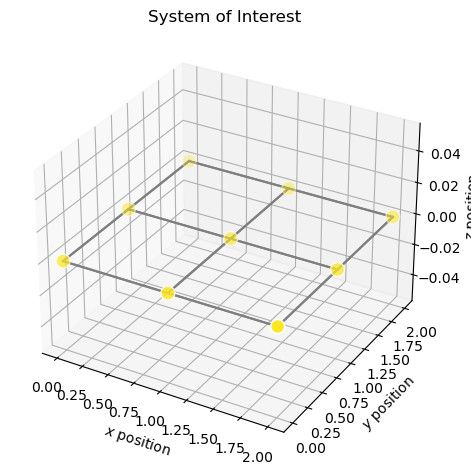

You won't see the periodic boundary edges in the plot, but here's a list:
periodic boundary edge between nodes 0/[0.0, 0.0, 0.0] and 6/[2.0, 0.0, 0.0].
periodic boundary edge between nodes 0/[0.0, 0.0, 0.0] and 2/[0.0, 2.0, 0.0].
periodic boundary edge between nodes 1/[0.0, 1.0, 0.0] and 7/[2.0, 1.0, 0.0].
periodic boundary edge between nodes 2/[0.0, 2.0, 0.0] and 8/[2.0, 2.0, 0.0].
periodic boundary edge between nodes 3/[1.0, 0.0, 0.0] and 5/[1.0, 2.0, 0.0].
periodic boundary edge between nodes 6/[2.0, 0.0, 0.0] and 8/[2.0, 2.0, 0.0].


In [6]:
# the .plot() method is available for sampling.Graph objects.

G.plot()

print("You won't see the periodic boundary edges in the plot, but here's a list:")
for e in G.edges():
    if G.edges[e]["periodic_boundary_edge"]:
        i = e[0]
        j = e[1]
        i_pos = G.nodes[i]["position"]
        j_pos = G.nodes[j]["position"]
        print("periodic boundary edge between nodes " 
            + str(i) + "/" + str(i_pos) + " and "
            + str(j) + "/" + str(j_pos) + "."
        )

### Additional `sampling.Graph` methods:

We created the `sampling.Graph` class so we could use call methods that would help us run various "sampling" routines an addition to the build-in methods for the `networkx.Graph` object.  The following cell demonstrates some of the methods.

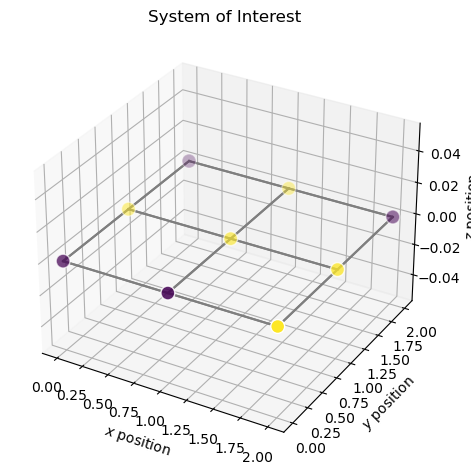

node: 0 / [0.0, 0.0, 0.0] spin: -1.0
node: 1 / [0.0, 1.0, 0.0] spin: 1.0
node: 2 / [0.0, 2.0, 0.0] spin: -1.0
node: 3 / [1.0, 0.0, 0.0] spin: -1.0
node: 4 / [1.0, 1.0, 0.0] spin: 1.0
node: 5 / [1.0, 2.0, 0.0] spin: 1.0
node: 6 / [2.0, 0.0, 0.0] spin: 1.0
node: 7 / [2.0, 1.0, 0.0] spin: 1.0
node: 8 / [2.0, 2.0, 0.0] spin: -1.0
The energy of the current spin configuration is:  1.9


In [7]:
# the number of nodes is n
n = len(G.nodes())

# generate random spin_config {-1,+1}^n
spin_config = sampling.generate_random_spin_config(n)

# set the spin_config:
G.set_spins(spin_config)

# Set external field B:
B = 0.1*np.ones(n)
G.set_external_field(B) # "get" function also available.

# Set the coupling strength J
# Notes:
# J_ij > 0 implies the model is ferromagnetic (JRS formulation)
# J_ij < 0 implies the model is antiferromagnetic
J = {e:1.0 for e in G.edges()}
G.set_couplings(J) # "get" function also available.

G.plot()

for i in G.nodes():
    print("node:",i,"/",G.nodes[i]["position"], "spin:",G.nodes[i]["spin"])

# Call the .energy() function to calculate the energy of the current state:
E = G.energy()
print("The energy of the current spin configuration is: ",E)

### Translating between `networkx.Graph` objects

To reiterate: a benchmark performer is not required to use any `networkx` or `sampling.py` functionality.  Use is optional.

We also want to be able translate the `sampling.Graph` objects between regular `networkx.Graph` objects and appropriate file formats.  The following cells demonstrate various ways to work with the objects.

In [8]:
# cast a sampling.Graph object into a networkx.Graph object:

# WARNING!  You won't have access to custom sampling.Graph.methods() after this!  But the properties of nodes/edges such as spin, external field, coupling strength are preserved.

G_nx = nx.Graph(G)


print("nodes:")
for i in G_nx.nodes():
    print(i,":", G_nx.nodes[i])

print("edges:")
for e in G_nx.edges():
    print(e,":", G_nx.edges[e])


nodes:
0 : {'position': [0.0, 0.0, 0.0], 'spin': -1.0, 'B': 0.1}
1 : {'position': [0.0, 1.0, 0.0], 'spin': 1.0, 'B': 0.1}
2 : {'position': [0.0, 2.0, 0.0], 'spin': -1.0, 'B': 0.1}
3 : {'position': [1.0, 0.0, 0.0], 'spin': -1.0, 'B': 0.1}
4 : {'position': [1.0, 1.0, 0.0], 'spin': 1.0, 'B': 0.1}
5 : {'position': [1.0, 2.0, 0.0], 'spin': 1.0, 'B': 0.1}
6 : {'position': [2.0, 0.0, 0.0], 'spin': 1.0, 'B': 0.1}
7 : {'position': [2.0, 1.0, 0.0], 'spin': 1.0, 'B': 0.1}
8 : {'position': [2.0, 2.0, 0.0], 'spin': -1.0, 'B': 0.1}
edges:
(0, 1) : {'weight': 1.0, 'periodic_boundary_edge': False}
(0, 3) : {'weight': 1.0, 'periodic_boundary_edge': False}
(0, 6) : {'weight': 1.0, 'periodic_boundary_edge': True}
(0, 2) : {'weight': 1.0, 'periodic_boundary_edge': True}
(1, 2) : {'weight': 1.0, 'periodic_boundary_edge': False}
(1, 4) : {'weight': 1.0, 'periodic_boundary_edge': False}
(1, 7) : {'weight': 1.0, 'periodic_boundary_edge': True}
(2, 5) : {'weight': 1.0, 'periodic_boundary_edge': False}
(2, 8) :

In [9]:
# initialize a sampling.Graph G object from a networkx.Graph G_nx:

G = sampling.Graph(G_nx)

# now we can use the additional methods provided in sampling.Graph
print("System energy:",G.energy())

System energy: 1.9


### Reading and writing files

The benchmark performer shall obtain graph topologies and specifications from the `benchmark_instances` folder.  The file format format is JSON. In addition to the obvious graph topology data, a problem instance file in the `benchmark_instances` folder will also have details on how each instance shall be run including:
* system temperature(s) $T$
* the number of samples $k$ the benchmark performer is required to generate and return
* time limit
* other metadata on the instance for tracking

See also https://networkx.org/documentation/stable/reference/readwrite/json_graph.html

The following cells demonstrate working with the file formats using `networkx` and `sampling.py` functionality.


In [10]:
# convert a sampling.Graph object or a networkx.Graph object to a dict:
graph_data = nx.node_link_data(G)

instance_uuid = "a8be0d9a-3238-11ee-b3fb-9309595bcf35"

# In The benchmark_instance file will also include a problem specification including 
benchmark_requirements = {"T":3.0, "k":1e3, "time_limit_seconds":600}
metadata = {
    "instance_uuid":instance_uuid,
    "graph_name":G.name,
    "graph_uuid":G.uuid,
    "related_instances":[
        "30aef17c-3236-11ee-b999-8bde4cb29835",
        "46771610-3236-11ee-8157-07c77723a277",
        "4658a090-3236-11ee-a3e2-ebb14598116a"
        ],
    "other_notes":"here are some more words."
    }

aggregated_dictionary = {
    "benchmark_requirements":benchmark_requirements,
    "metadata":metadata,
    "graph_data":graph_data
}

filename = "benchmark_instances/instance." + instance_uuid + ".json"

# write the dict as JSON to a file
output_bytes = json.dumps(aggregated_dictionary).encode("utf8")
with open(filename,"wb") as f:
    f.write(output_bytes)
    f.close()

# read the bytes from a file
with open(filename,"rb") as f:
    read_bytes = f.read()
    f.close()

# convert the byte array to a dict
readback_dictionary = json.loads(read_bytes)
readback_graph_data = readback_dictionary["graph_data"]

# create a new networkx.Graph (*NOT* a sampling.Graph) object from the JSON
G_nx = nx.node_link_graph(readback_graph_data)


# initialize a new sampling.Graph object from the networkx.Graph object
G = sampling.Graph(G_nx)

# use some sampling.Graph method:
print("Spin configuration:", G.get_spins())
print("Energy:",G.energy())

Spin configuration: [-1.  1. -1. -1.  1.  1.  1.  1. -1.]
Energy: 1.9


By reading in some `benchmark_instances/instance.<uuid>.json` file, the benchmark performer is given all the information they need to complete the benchmark (by whatever algorithm or hardware they choose).

The benchmark performer is required to submit a solution file in the following format:  TODO!  TBD!  basically a list or histogram-like count of all $k$ samples produced and some relevant metadata on who the benchmark performer is, what hardware/algorithm they ran, wall clock time, etc.  This file format is **important** because we will read it in to perform verification of samples.  The submission file may be large, so we should consider compression and/or .hdf5 format.